### Handwritten Digits Classification Project with CNN

#### 1. Business Problem:

- El yazısıyla yazılmış olan rakamların görüntüleri çekilmiş ve bunlardan veri seti oluşturulmuş.

- Projede kullanılacak veri setinin adı "MNIST"dir.(Modified National Institute of Standards and Technology)

- Piksel, insan gözünün bir görüntüde(image) ayırt edebileceği en küçük birimdir. Veri setindeki görüntüler 28*28'lik  piksellerden oluşmaktadır.

- Veri setinde 60.000 tanesi eğitim veri seti(train dataset), 10.000 tanesi de test veri seti olmak üzere toplamda 70.000 görüntü(image) ya da fotoğraf bulunmaktadır.

- Bu projede CNN(convolutional neural network) derin öğrenme mimarisi kullanılacaktır.

#### 2. Data Understanding:

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist #kullanacağımız veri seti tensorflow kütüphanesi içinde vardır zaten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical # encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

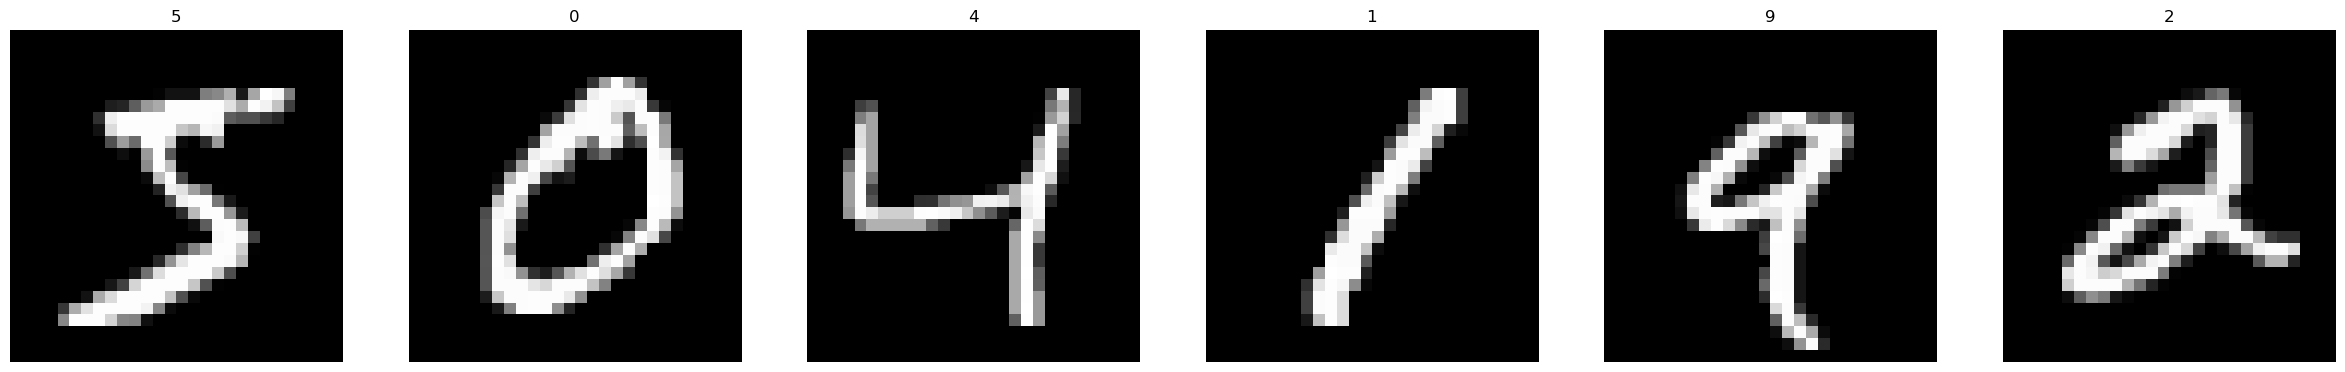

In [3]:
# Görselleştirme
class_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

fig, axes = plt.subplots(1, 6, figsize = (30, 24))
for i in range(6):
    axes[i].imshow(x_train[i], cmap = "gray")
    label = class_labels[y_train[i]]
    axes[i].set_title(label)
    axes[i].axis("off")

plt.show()

#### 3. Data Preparation:

In [4]:
#------------------------- Normalization -------------------------
# normalize etmek demek 0 ile 1 arasına sıkıştırmak yani scale etmek demektir bu nedenle 255'e böleriz
# input değerlerinin yani görsellerdeki piksel değerlerinin 0 ila 1 arasında değer almaları sağlanıyor.

x_train = x_train.astype('float32') / 255 

x_test = x_test.astype('float32') / 255

In [5]:
# boyutlarının (28, 28, 1) olması gerekiyor yani görüntünün kaç channel'lı(burda 1 yani siyah-beyaz) old. belirtmesi lazım
print(f"x_train boyutu: {x_train.shape}")
print(f"x_test boyutu: {x_test.shape}")

x_train boyutu: (60000, 28, 28)
x_test boyutu: (10000, 28, 28)


In [6]:
#------------------------ Reshaping -------------------------------------
# reshape for grayscale(add channel dimension)
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)

In [7]:
print(f"x_train boyutu: {x_train.shape}")
print(f"x_test boyutu: {x_test.shape}")

x_train boyutu: (60000, 28, 28, 1)
x_test boyutu: (10000, 28, 28, 1)


In [8]:
#------------------------- Encoding, One-Hot Encoding -------------------------------
# encode işlemini hem y_train hem de y_test setine uygulamalıyız. Bu işlem ile veriyi kategorik hale getiririz 

y_train = to_categorical(y_train, 10) # y_train içinde 10 tane unique değer vardır
y_test = to_categorical(y_test, 10)

In [9]:
y_train[200]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
y_train[599]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [11]:
# Önce "data augmentation" yapıyoruz, 'gerçek dünya özelliği' ya da diğer ifadesiyle 'gürültü(noise)' ekleme ihtiyacına karşılık

# "ImageDataGenerator" fonksiyonunun görevi veri üretmektir, gerçek zamanlı veri çeşitlendirme yapmaktadır.
datagen = ImageDataGenerator(horizontal_flip = True, # görüntü yatayda ters çevrilecek
                             rotation_range  = 20, # 20 dereceye kadar döndürme sağlar
                             fill_mode = "nearest", # boş alanları doldurmak için en yakın piksel değerlerini kullan
                             shear_range = 0.2, # görüntü üzerinde kaydırma
                             zoom_range = 0.2,
                             width_shift_range = 0.2, # görüntüyü yatayda %20 kaydırma
                             height_shift_range = 0.2) # görüntüyü dikeyde %20 kaydırma

In [12]:
datagen.fit(x_train) # data augmentation'ı eğitim verileri üzerine uygula

#### 4. Modelling:

In [13]:
model = Sequential()

# bu katmanda giriş katmanı üzerinden öznitelik çıkarımı yapılır,"filters=32" ifadesi görüntü üzerinde gezdirilecek 32 tane filtre var demek
# padding='same' ise evrişim işlemi sonrasında giriş matrisi ile çıkış matrisi boyutunun birbirine eşit olması için piksel eklemedir
# aktivasyon fonksiyonu bilgisi zaten convolution katmanında verildi.

# feature extraction : conv -> relu -> conv -> relu -> pool -> dropout
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # özellik kaybetmeden boyut azaltma işlemidir, bu katmanda öğrenme işlemi yapılmamaktadır
model.add(Dropout(rate=0.25))

# feature extraction : conv -> relu -> conv -> relu -> pool -> dropout
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # özellik kaybetmeden boyut azaltma işlemidir, bu katmanda öğrenme işlemi yapılmamaktadır
model.add(Dropout(rate=0.3))


# classification : flatten -> dense -> relu -> dropout -> output
# flatten katmanı, verilerimizi yapay sinir ağı girişine uygun hale getiririz bu katmanda yani tek boyutlu matris haline
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=10, activation='softmax'))

# Dense katmanı katmanlar arasında nöron ya da düğümlerin geçişini sağlar yani bir katmandan aldığı nöronların bir sonraki katmana girdi 
# olarak bağlanmasını sağlar, buradaki 'units' nöron sayısını ifade eder 
# output layer, 10 sınıflı bir sınıflandırma problemi old. için units=10 dedik

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 889,834 (3.39 MB)

 Trainable params: 889,834 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
################ Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması ################

# compile, modeli şunlara göre(verilen parametrelere göre) derle demektir
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001, decay=1e-6),
    metrics=["accuracy"]
)

In [16]:
# model training

history = model.fit(datagen.flow(x_train, y_train, batch_size = 512),
                     epochs = 20,
                     validation_data = (x_test, y_test))

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.2920 - loss: 1.9616 - val_accuracy: 0.7275 - val_loss: 0.9102
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 282ms/step - accuracy: 0.6552 - loss: 1.0347 - val_accuracy: 0.9114 - val_loss: 0.2844
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 282ms/step - accuracy: 0.7695 - loss: 0.7106 - val_accuracy: 0.9337 - val_loss: 0.2125
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 283ms/step - accuracy: 0.8264 - loss: 0.5475 - val_accuracy: 0.9623 - val_loss: 0.1154
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - accuracy: 0.8642 - loss: 0.4237 - val_accuracy: 0.9717 - val_loss: 0.0879
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.8922 - loss: 0.3428 - val_accuracy: 0.9718 - val_loss: 0.0853
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.9062 - loss: 0.3036 - val_accuracy: 0.9757 - val_loss: 0.0709
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 292ms/step - accuracy: 0.9222 - loss: 0

#### 5. Evaluation:

In [17]:
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [18]:
y_pred_class = np.argmax(y_pred, axis = 1)

In [19]:
y_true = np.argmax(y_test, axis = 1)

In [20]:
report = classification_report(y_true, y_pred_class, target_names = class_labels)

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.97      0.98      0.97       892
           6       0.98      0.99      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



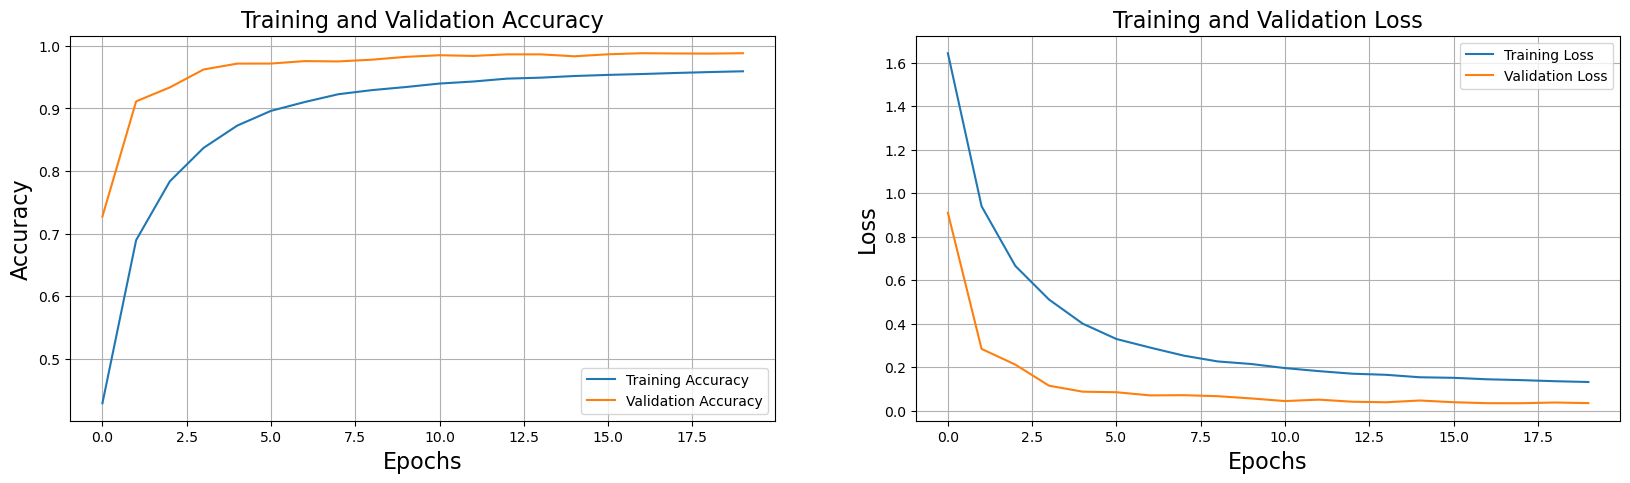

In [23]:
####################################################
# Accuracy Graph
####################################################

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True)
plt.title('Training and Validation Accuracy', fontsize=16)


####################################################
# Loss Graph
####################################################

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation Loss', fontsize=16)
plt.grid(True)
plt.show()